In [4]:
import torch
import torchvision
import numpy as np
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [5]:
dataset = FashionMNIST(root='data/',download=True,transform=ToTensor())


100%|██████████| 26421880/26421880 [00:02<00:00, 11176871.51it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201665.98it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3772279.13it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6026312.31it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
test_dataset = FashionMNIST(root='data/',train=False,transform = ToTensor())


In [7]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [8]:
batch_size = 128

In [44]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size = 2*batch_size, shuffle = False, num_workers=2,pin_memory=True)
test_dl = DataLoader(val_ds,batch_size = 2*batch_size, shuffle = True, num_workers=2,pin_memory=True)

torch.Size([128, 1, 28, 28]) ==image.shape


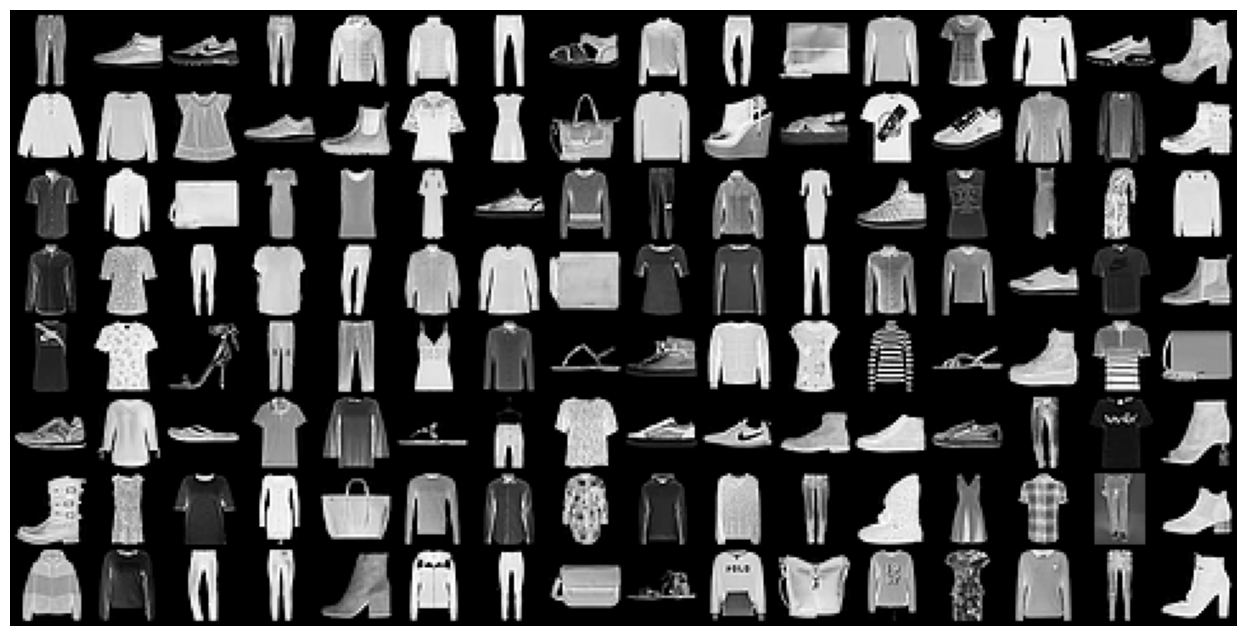

In [10]:
for images, labels in train_dl:
  print(images.shape, '==image.shape' )
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

In [11]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return  torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [12]:
input_size = 784
hidden_input = 16
hidden_output = 32
output_size = 10

In [13]:
class FashionMnist(nn.Module):
  def __init__(self,input_size,hidden_input,hidden_output,output_size):
    super().__init__()
    self.layer1 = nn.Linear(input_size,hidden_input)
    self.layer2 = nn.Linear(hidden_input,hidden_output)
    self.layer3 = nn.Linear(hidden_output,output_size)

  def forward(self,xb):
    out = xb.view(xb.size(0),-1)
    out = self.layer1(out)
    out = F.relu(out)
    out = self.layer2(out)
    out = F.relu(out)
    out = self.layer3(out)
    return out
  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  def validation_step(self,batch):
    images,labels  = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss, 'val_acc':acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    batch_loss = torch.sum(torch.tensor(batch_losses))/len(batch_losses)
    batch_accs = [x['val_acc'] for x in outputs]
    batch_acc = torch.sum(torch.tensor(batch_accs))/len(batch_accs)
    return {'vals_acc':batch_acc,'vals_loss':batch_loss}
  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['vals_loss'], result['vals_acc']))

In [14]:
model = FashionMnist(input_size, hidden_input, hidden_output, output_size)

In [15]:
def evaluate(model, val_dl):
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)


def fit (epochs, lr,model,train_dl,val_dl,opt_func=torch.optim.SGD ):
  optimizer = opt_func(model.parameters(), lr)
  history = []
  for epoch in range(epochs):
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    results = evaluate(model,val_dl)
    model.epoch_end(epoch,results)
    history.append(results)

  return history



In [16]:
lr = 0.1
epochs = 10


In [17]:
history=[evaluate(model,val_dl)]
history

[{'vals_acc': tensor(0.1005), 'vals_loss': tensor(2.3079)}]

In [18]:
history += fit(epochs,lr,model, val_dl, train_dl)

Epoch [0], val_loss: 1.7028, val_acc: 0.4579
Epoch [1], val_loss: 1.4602, val_acc: 0.4994
Epoch [2], val_loss: 1.2207, val_acc: 0.5887
Epoch [3], val_loss: 1.0255, val_acc: 0.6396
Epoch [4], val_loss: 0.8983, val_acc: 0.6845
Epoch [5], val_loss: 0.8332, val_acc: 0.7026
Epoch [6], val_loss: 0.8038, val_acc: 0.7087
Epoch [7], val_loss: 0.7737, val_acc: 0.7157
Epoch [8], val_loss: 0.7383, val_acc: 0.7243
Epoch [9], val_loss: 0.7101, val_acc: 0.7310


In [19]:
history += fit(epochs,lr,model, val_dl, train_dl)

Epoch [0], val_loss: 0.6780, val_acc: 0.7431
Epoch [1], val_loss: 0.6508, val_acc: 0.7559
Epoch [2], val_loss: 0.6246, val_acc: 0.7680
Epoch [3], val_loss: 0.6080, val_acc: 0.7743
Epoch [4], val_loss: 0.5902, val_acc: 0.7826
Epoch [5], val_loss: 0.5808, val_acc: 0.7874
Epoch [6], val_loss: 0.5709, val_acc: 0.7920
Epoch [7], val_loss: 0.5633, val_acc: 0.7943
Epoch [8], val_loss: 0.5631, val_acc: 0.7950
Epoch [9], val_loss: 0.5572, val_acc: 0.7973


In [20]:
history += fit(epochs,lr,model, val_dl, train_dl)

Epoch [0], val_loss: 0.5573, val_acc: 0.7962
Epoch [1], val_loss: 0.5490, val_acc: 0.8004
Epoch [2], val_loss: 0.5485, val_acc: 0.7999
Epoch [3], val_loss: 0.5461, val_acc: 0.8014
Epoch [4], val_loss: 0.5414, val_acc: 0.8029
Epoch [5], val_loss: 0.5400, val_acc: 0.8031
Epoch [6], val_loss: 0.5300, val_acc: 0.8074
Epoch [7], val_loss: 0.5336, val_acc: 0.8061
Epoch [8], val_loss: 0.5270, val_acc: 0.8081
Epoch [9], val_loss: 0.5231, val_acc: 0.8094


In [24]:
history += fit(epochs,lr,model, val_dl, train_dl)

Epoch [0], val_loss: 0.5189, val_acc: 0.8111
Epoch [1], val_loss: 0.5077, val_acc: 0.8183
Epoch [2], val_loss: 0.5201, val_acc: 0.8115
Epoch [3], val_loss: 0.5031, val_acc: 0.8206
Epoch [4], val_loss: 0.5169, val_acc: 0.8130
Epoch [5], val_loss: 0.5035, val_acc: 0.8191
Epoch [6], val_loss: 0.5134, val_acc: 0.8139
Epoch [7], val_loss: 0.4957, val_acc: 0.8219
Epoch [8], val_loss: 0.5039, val_acc: 0.8187
Epoch [9], val_loss: 0.4865, val_acc: 0.8250


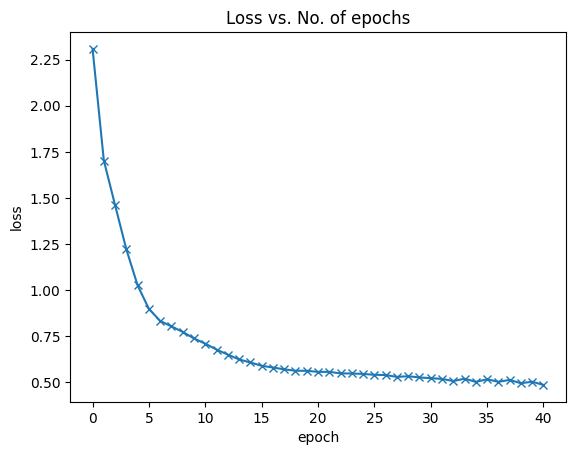

In [25]:
losses = [x['vals_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

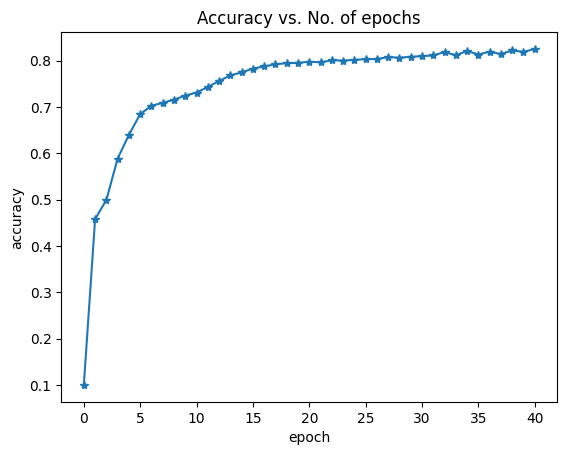

In [31]:
accuracies = [x['vals_acc'] for x in history]
plt.plot(accuracies, '-*')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [41]:
evaluate(model, test_dl)

{'vals_acc': tensor(0.8565), 'vals_loss': tensor(0.3840)}

In [42]:
def test_eval(model, test_dl):
  outputs = [model.validation_step(batch) for batch in test_dl]
  return model.validation_epoch_end(outputs)

In [46]:
test_eval(model,test_dl)

{'vals_acc': tensor(0.8521), 'vals_loss': tensor(0.3951)}

In [47]:
FashionMnist_weights = 'FashionMnist_weights.pth'
torch.save(model.state_dict(),FashionMnist_weights)